In [1]:
import torch
import torchvision
from lib.data_handlers import Load_ImageNet100, Load_PACS, Load_ImageNet100Sketch
from overcomplete.models import DinoV2, ViT, ResNet, ViT_Large, SigLIP
from torch.utils.data import DataLoader, TensorDataset
from overcomplete.sae import TopKSAE, train_sae
from overcomplete.visualization import (overlay_top_heatmaps, evidence_top_images, zoom_top_images, contour_top_image)
import os
import matplotlib.pyplot as plt
from einops import rearrange
from lib.universal_trainer import train_usae
from lib.activation_generator import Load_activation_dataloader
import torch.nn as nn
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
from lib.eval import evaluate_models
from lib.visualizer import visualize_concepts
from tqdm import tqdm
import timm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()


c:\Users\sproj_ha\miniconda3\envs\interpretability\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
models = {
    "ViT": ViT(device="cuda")
}

activations_dir="/activations/ViT_Solo"

image_loader, image_dataset = Load_ImageNet100(transform=None, batch_size=256, shuffle=True, dataset=True)

activations_dataloader = Load_activation_dataloader(
    models=models,
    image_dataloader=image_loader,
    max_seq_len=196,
    save_dir=activations_dir,
    generate=False,
    rearrange_string='n t d -> (n t) d'
)

concepts = 768 * 8
epochs = 100
lr=3e-4
sample = next(iter(activations_dataloader))

SAEs = {}
optimizers = {}
schedulers = {}

for key, model in models.items():

    SAEs[key] = TopKSAE(
        sample[f"activations_{key}"].shape[-1],
        nb_concepts=concepts,
        top_k=16,
        device="cuda",
    )
    optimizers[key] = torch.optim.Adam(SAEs[key].parameters(), lr=lr)

    # Set up a Linear + Cosine Scheduler
    warmup_scheduler = LinearLR(
        optimizers[key], start_factor=1e-6 / 3e-4, end_factor=1.0, total_iters=10
    )
    cosine_scheduler = CosineAnnealingLR(optimizers[key], T_max=epochs, eta_min=1e-6)
    schedulers[key] = SequentialLR(
        optimizers[key],
        schedulers=[warmup_scheduler, cosine_scheduler],
        milestones=[25],
    )

criterion = nn.L1Loss(reduction="mean")  # change to mean reduction

model_path = "./models/ViT_MLP.pt"
state = torch.load(model_path)

for name, sae in SAEs.items():
    print(sae.load_state_dict(state[name]))

<All keys matched successfully>


In [5]:
sae = SAEs['ViT']

torch.Size([1, 14, 14, 6144])


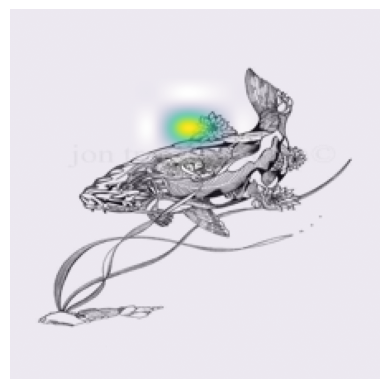

In [57]:
from PIL import Image
from torchvision import transforms
from overcomplete.visualization.plot_utils import (
    get_image_dimensions,
    interpolate_cv2,
    show,
)
from overcomplete.visualization.cmaps import VIRIDIS_ALPHA

transform = transforms.ToTensor()
vit = models['ViT']



CONCEPT = 2103




x = Image.open(r"C:\Users\sproj_ha\Desktop\vision_interp\datasets\imagenetsketch\sketch\n01440764\sketch_35.JPEG")
#x = Image.open(r"C:\Users\sproj_ha\Desktop\vision_interp\datasets\imagenet100\train.X1\n01756291\n01756291_142.JPEG")
x = vit.preprocess(x).unsqueeze(dim=0)



y = vit.forward_features(x.to(device))
y = rearrange(y, 'n t d -> (n t) d')

_, z_sae = sae.encode(y)

z = rearrange(z_sae, '(n w h) d -> n w h d', w=14, h=14)


print(z.shape)

width, height = x.shape[-1], x.shape[-2]
heatmap = interpolate_cv2(z[:, :, :, CONCEPT], (width, height))

show(x)
show(heatmap, cmap=VIRIDIS_ALPHA, alpha=1.0)

plt.show()


In [37]:
z[:, :, :, 2103]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0

In [38]:
z[:, :, :, 4395]

tensor([[[19.9766, 14.3027,  7.7557,  0.0000,  0.0000,  0.0000,  3.6836,
          17.3181, 20.1870, 22.0441, 23.2858, 31.1823,  0.0000, 22.2857],
         [24.5803, 18.8284,  0.0000, 19.3685,  0.0000, 15.0874, 22.0635,
          13.4357, 25.7941, 26.1300, 21.0075, 24.5400, 28.1543, 24.3410],
         [30.0213, 12.0903, 18.1600,  7.4773, 13.5518, 16.3262, 21.9222,
           0.0000, 26.8441, 29.0237, 31.1096, 29.7123, 29.4751, 17.5995],
         [15.7591,  0.0000, 11.4290, 18.0678, 14.1870, 15.5788, 11.9302,
           3.7486, 19.5462, 31.5032, 28.4118, 24.2155, 28.7570, 30.3989],
         [19.2333, 26.9912, 30.7342, 27.6582, 32.3362,  0.0000, 24.5212,
          27.2884, 23.9400, 25.0193, 24.5292, 23.8809, 22.9710, 21.0826],
         [28.8186, 27.9392, 29.8642, 29.1240, 28.0282,  2.5779, 25.8641,
          21.1394, 19.5301, 19.0142, 16.2736, 18.8964, 23.3597, 29.4259],
         [25.0967, 29.2316,  0.0000, 26.3386, 26.7003, 25.3071, 26.7243,
          19.8372, 23.6092, 17.9762, 10.4967,